# Testing LDMNet on toy data

To verify the implementation of LDMNet, this notebook includes some experiments with toy data.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

from scipy import sparse
from LDMM import LDMNetSkorch, SaveLDMNetVars
%run LDMM_plot_utils.py
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import (EarlyStopping, NaNStopping, MLP, NNClassifier, 
                          SaveWeights, LRScheduler, learning_curve)
from skorch.utils import to_numpy

from scipy.stats import uniform, reciprocal
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.decomposition import PCA

import pandas as pd

random_state=0
plt.rcParams['image.cmap'] = 'RdBu'

## Generating data: S curve (2D surface on 3D coords)
Toy data for this experiments is an S shaped surface generated by `sklearn`'s function `make_s_curve`.
Each point is returned with a continuous value as label, which is quantized in two discrete values to generate a binary classification problem. Continuous values will be kept only for visualization purposes.

We generate 100 points with no noise. Bellow, 3D plots of the surface and a 2D plot made via PCA dimensionality reduction.


In [3]:
from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=100, noise=0, random_state=random_state)
y_orig = y
N = 2
# for more than 2 clases
hist, bin_edges = np.histogram(y, bins=N)
y = np.digitize(y, bin_edges[:-1])-1
X = X.astype(np.float32)
y = y.astype(np.int64)

Text(0.5,1,'PCA on S - variance ratio: 0.7 0.2 0.1')

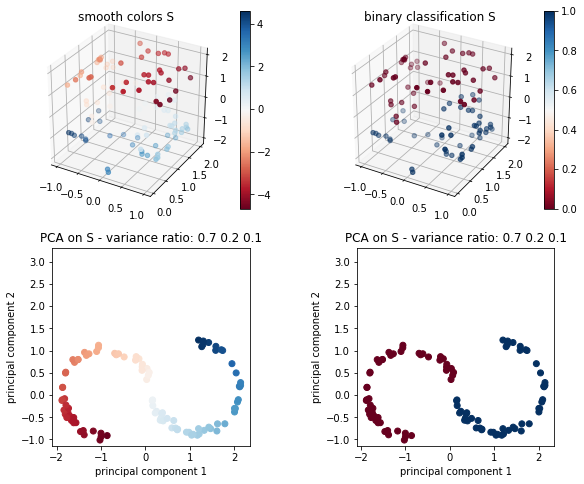

In [4]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221, projection='3d')
plt.title('smooth colors S')
p = ax.scatter(*X.T, c=y_orig)
plt.colorbar(p)
ax = fig.add_subplot(222, projection='3d')
plt.title('binary classification S')
p = ax.scatter(*X.T, c=y)
plt.colorbar(p)
proj = PCA(n_components=3, random_state=random_state)
X2d = proj.fit_transform(X)
plt.subplot(2,2, 3)
plt.scatter(*X2d[:,0:2].T, c=y_orig)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.axis('square')
plt.title("PCA on S - variance ratio: %0.1f %0.1f %0.1f" % tuple(proj.explained_variance_ratio_[0:3]))
plt.subplot(2,2, 4)
plt.scatter(*X2d[:,0:2].T, c=y)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.axis('square')
plt.title("PCA on S - variance ratio: %0.1f %0.1f %0.1f" % tuple(proj.explained_variance_ratio_[0:3]))

### Sanity check: Simple neural net
Checking how an 8 neuron 1 hidden layer MLP solves the problem. 20% of training data is held out as validation for deciding on early stopping neural network training.

In [5]:
torch.manual_seed(random_state)
module = MLP(X.shape[1], 8, N, drop_proba=0.5)
simple_model = NNClassifier(
    module=module,
    max_epochs=600,
    batch_size=100,
    lr=0.009,
    use_cuda=True,
    verbose=0,
    callbacks=[EarlyStopping(5, 'valid_loss'),
               NaNStopping()]
)

In [6]:
_ = simple_model.fit(X, y)

In [7]:
learning_curve(simple_model)

Text(0,0.5,'principal component 2')

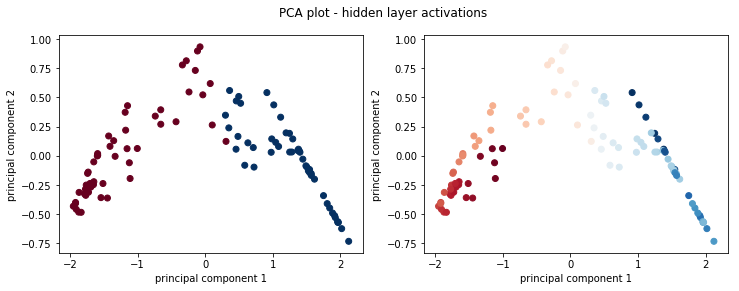

In [8]:
ksi = simple_model.transform(X, name='hidden1')
y_pred = simple_model.predict(X)
ksi2d = PCA(n_components=2).fit_transform(ksi)
plt.figure(figsize=(12,4))
plt.suptitle('PCA plot - hidden layer activations')
plt.subplot(1,2,1)
plt.scatter(*ksi2d.T, c=y)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.subplot(1,2,2)
plt.scatter(*ksi2d.T, c=y_orig)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

## Training LDMNet
Here we train LDMNet based on the same MLP as before. Same early stopping heuristics apply.

In [20]:
torch.manual_seed(random_state)

max_epochs = 2000

module = MLP(X.shape[1], 8, N, drop_proba=0)
model = LDMNetSkorch(
    module=module,
    layer_name='hidden1',
    max_epochs=max_epochs,
    batch_size=100,
    lr=0.009,
    mu=0.0003, lambda_bar=0.25,
    use_cuda=True,
    verbose=1,
    callbacks=[EarlyStopping(5, 'valid_loss'),
               NaNStopping(), 
               SaveWeights(every_n_epochs=100),
               SaveLDMNetVars(every_n_epochs=50)]
)

The network trains for `max_epochs`={{max_epochs}}, but can be early stopped if the validation loss does not improve.

In [9]:
torch.manual_seed(random_state)

max_epochs = 2000

module = MLP(X.shape[1], 8, N, drop_proba=0)
model = LDMNetSkorch(
    module=module,
    layer_name='hidden1',
    max_epochs=max_epochs,
    batch_size=100,
    lr=0.009,
    mu=0.0003, lambda_bar=0.25,
    use_cuda=True,
    verbose=1,
    callbacks=[EarlyStopping(5, 'valid_loss'),
               NaNStopping(), 
               SaveWeights(every_n_epochs=100),
               SaveLDMNetVars(every_n_epochs=50)]
)

### Hyper parameters - random search
We choose to adjust the learning rate `lr`, the ADMM mutiplier `mu` and the regularization parameter `lambda_bar` ($\tilde{\lambda}$ in the paper). 20% of training is held out as validation data to evaluate each parameter set.

In [10]:
n_hparams = 100

params = {
'lr': uniform(1e-4, 1e-2),
'mu': reciprocal(1e-5, 1.0),
'lambda_bar': uniform(1e-1, 10.0)
}

search = RandomizedSearchCV(
    model, n_iter=n_hparams, n_jobs=1,
    cv=StratifiedShuffleSplit(1, test_size=0.2, random_state=random_state),
    refit=True, random_state=random_state,
    param_distributions=params, verbose=1)

We search for `n_hparams`={{n_hparams}} sets of hyper-parameters.

In [11]:
import os
DIR = 'LDMNetScurve/%d_hparams_%d_max_epochs/' % (n_hparams, max_epochs)
FILE = 'save.pkl'
os.makedirs(DIR, exist_ok=True)
fname = os.path.join(DIR, FILE)
if not os.path.exists(fname):
    search.fit(X,y)
    pd.to_pickle({'search': search}, fname)
else:
    saved = pd.read_pickle(fname)
    search = saved['search']
model = search.best_estimator_

#### Hyper-parameters - best set
The model is retrained over the complete training set using the best parameters found. Here are the parameters and the accuracy over the training set.

In [12]:
model = search.best_estimator_
print("best params", search.best_params_)
print("validation accuracy", model.score(X, y))

best params {'lambda_bar': 5.588135039273247, 'lr': 0.007251893663724195, 'mu': 0.010323260351976567}
validation accuracy 1.0


#### Hyper-parameters - best parameter sets in the hyper-parameter space
Here only the other parameter-sets yielding validation accuracy better than 90%

In [13]:
results = search.cv_results_
results = pd.DataFrame(results)
df=pd.DataFrame(results, columns=['param_lambda_bar', 'param_lr', 'param_mu'])

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


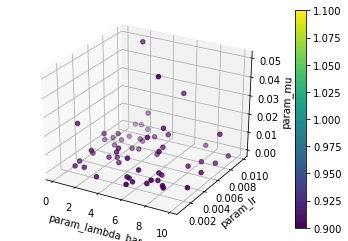

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mask = results.mean_test_score.values > 0.9
p = ax.scatter(*df.values[mask].T, c=results.mean_test_score.values[mask], cmap='viridis')
set_labels = lambda x, y, z: (ax.set_xlabel(x), ax.set_ylabel(y), ax.set_zlabel(z))
set_labels(*df.columns.values)
plt.colorbar(p)

### Observing LDMNet training

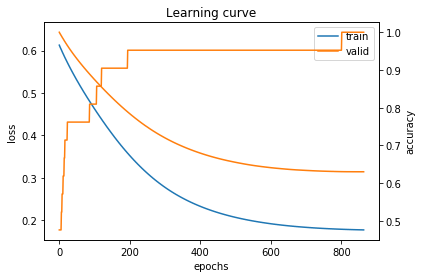

In [15]:
learning_curve(model)

#### PCA plots of feature space ksi
Here we plot 2D - PCA views of the hidden layer activations -- `ksi`-- and of the perturbed coordinate functions `alpha` to which they are regularized, as the iterations proceed.

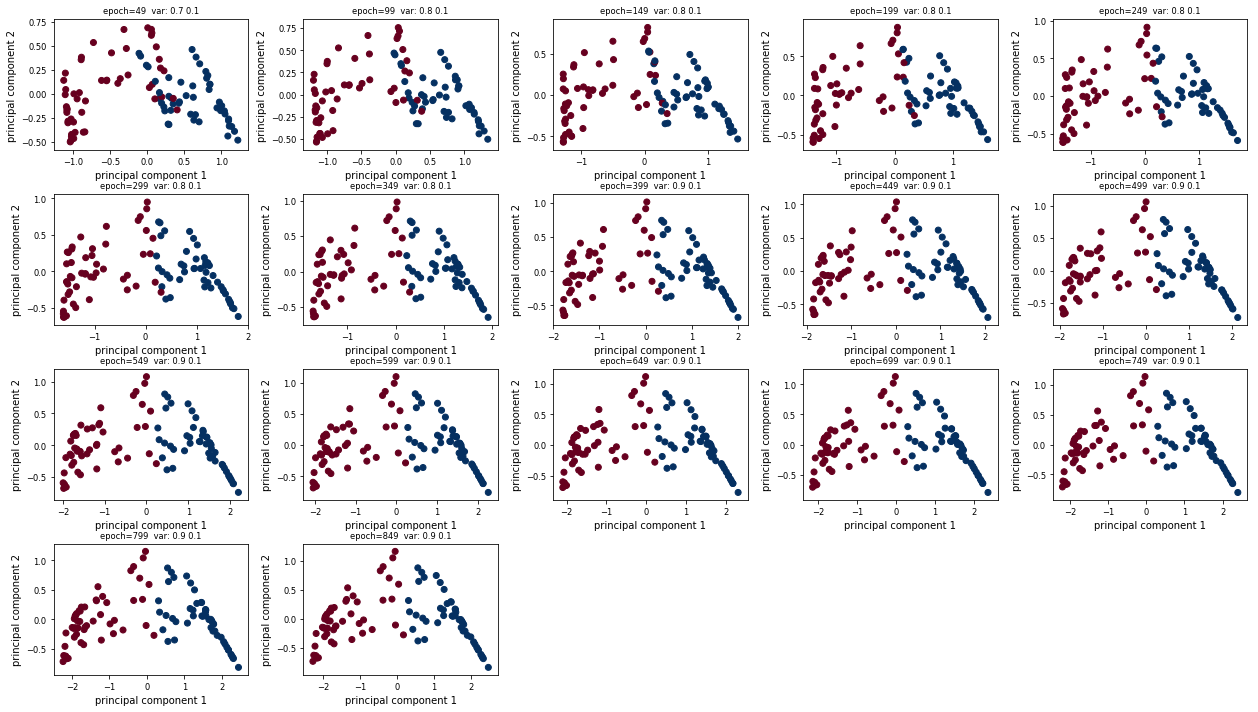

In [16]:
%run LDMM_plot_utils.py
plt.rcParams['image.cmap'] = 'RdBu'
plot_over_time(model, 'ksi', every_n=1, y=y)
plt.tight_layout(h_pad=0.1)

In this plot, the PCA is calculated at each time step for `alpha` and the same projection is used to plot `ksi`. The idea is to see in a common space how different were `ksi` and `alpha` during the optimization.

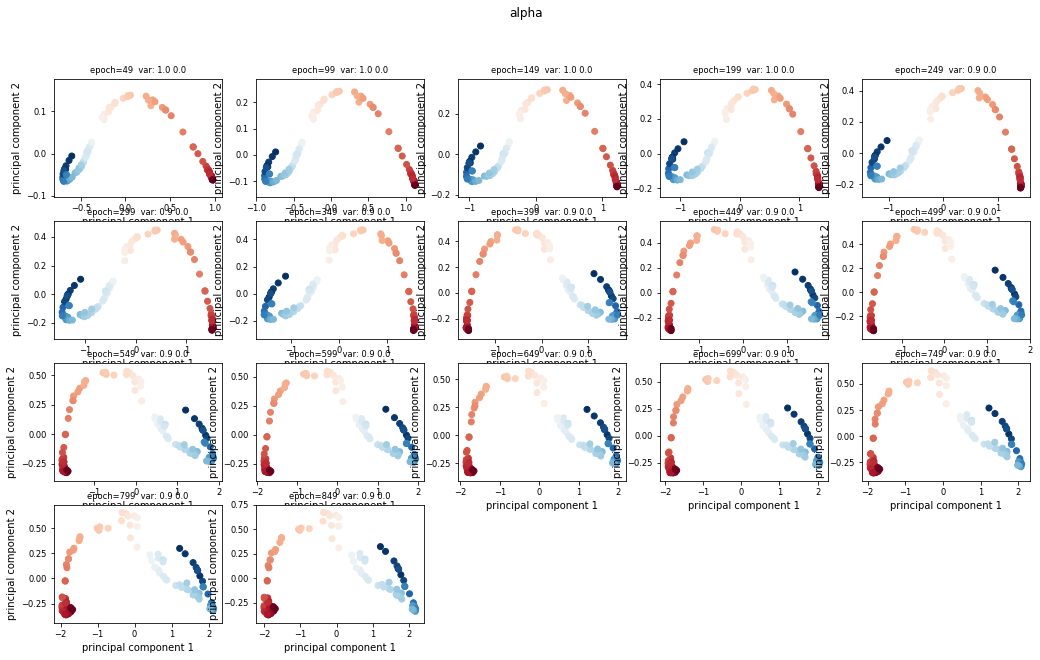

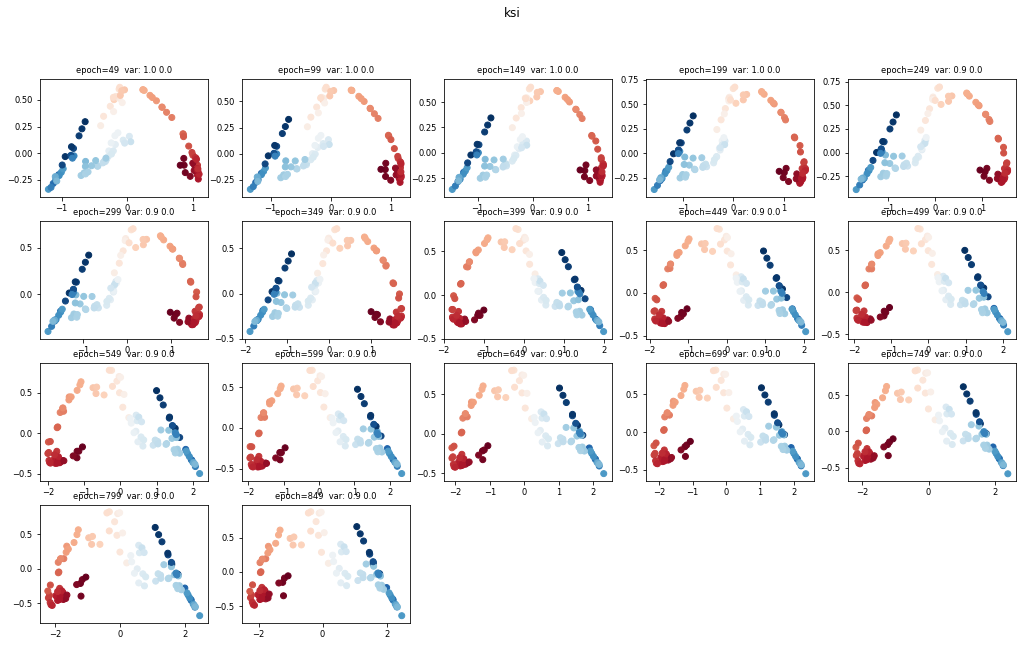

In [17]:
plot_ksi_alpha_time(model, every_n=1, y=y_orig)
#plt.tight_layout(h_pad=0.1)

#### Average values per feature along the iterations
To get a sense of the convergence, here we plot average values per feature (i.e. per neuron of the hidden layer) of : 
- `alpha`
- dual variable `Z`
- activations `ksi`
- weights and bias of the hidden and output layers

We also plot their variations -- delta -- along the iterations. A smothing window is used for delta `alpha` and delta `Z`.
##### Evolution of Z, alpha and ksi

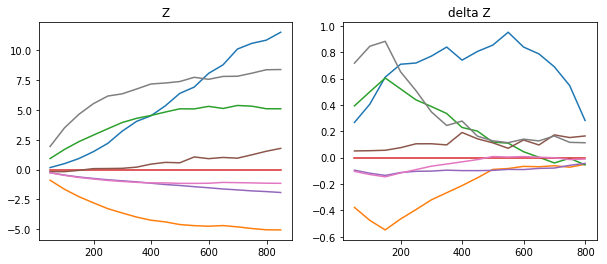

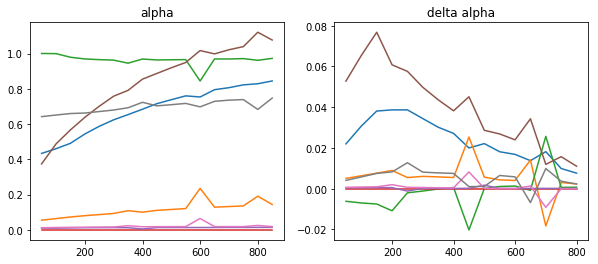

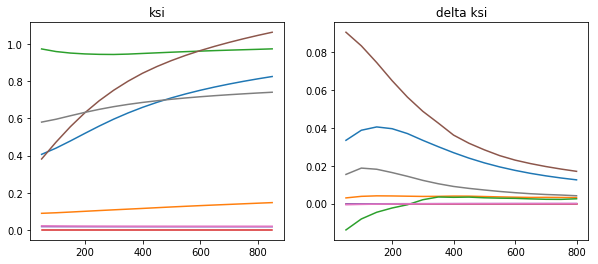

In [18]:
plot_ldmm_vars(model, 'Z', smooth_delta=5)
plot_ldmm_vars(model, 'alpha', smooth_delta=5)
plot_ldmm_vars(model, 'ksi', smooth_delta=0)

##### Evolution of weights and bias 

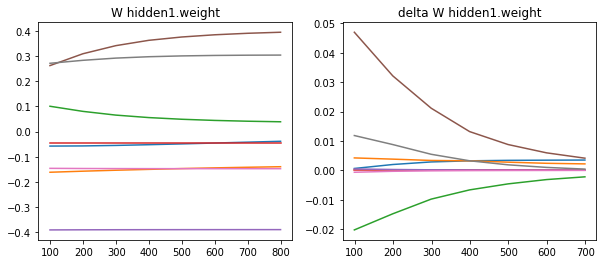

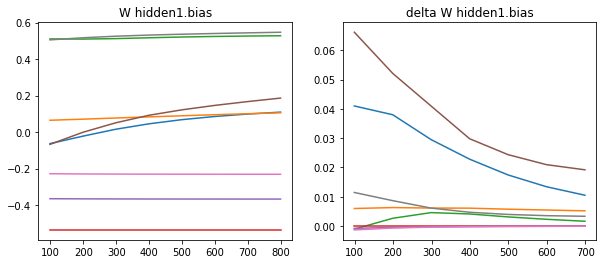

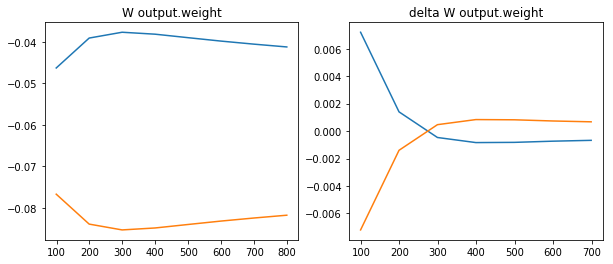

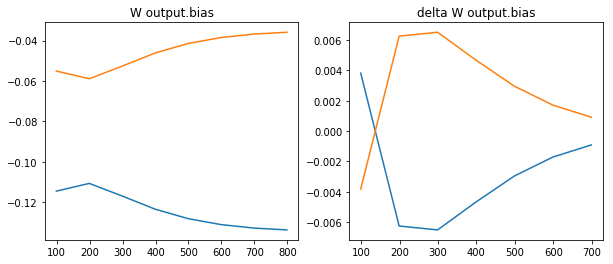

In [19]:
plot_net_weights(model, 'hidden1', smooth_delta=0)
plot_net_weights(model, 'output', smooth_delta=0)